# Train a ConvNet!
We now have a generic solver and a bunch of modularized layers. It's time to put it all together, and train a ConvNet to recognize the classes in CIFAR-10. In this notebook we will walk you through training a simple two-layer ConvNet and then set you free to build the best net that you can to perform well on CIFAR-10.

Open up the file `cs231n/classifiers/convnet.py`; you will see that the `two_layer_convnet` function computes the loss and gradients for a two-layer ConvNet. Note that this function uses the "sandwich" layers defined in `cs231n/layer_utils.py`. 

In [1]:
# As usual, a bit of setup

import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifier_trainer import ClassifierTrainer
from cs231n.gradient_check import eval_numerical_gradient
from cs231n.classifiers.convnet import *

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context("notebook", font_scale=1.15, rc={"lines.linewidth": 2.5})
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    
    # Transpose so that channels come first
    X_train = X_train.transpose(0, 3, 1, 2).copy()
    X_val = X_val.transpose(0, 3, 1, 2).copy()
    x_test = X_test.transpose(0, 3, 1, 2).copy()

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print( 'Train data shape: ', X_train.shape)
print( 'Train labels shape: ', y_train.shape)
print( 'Validation data shape: ', X_val.shape)
print( 'Validation labels shape: ', y_val.shape)
print( 'Test data shape: ', X_test.shape)
print( 'Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3, 32, 32)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3, 32, 32)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


# Sanity check loss
After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization this should go up.

In [3]:
model = init_two_layer_convnet()

X = np.random.randn(100, 3, 32, 32)
y = np.random.randint(10, size=100)

loss, _ = two_layer_convnet(X, model, y, reg=0)

# Sanity check: Loss should be about log(10) = 2.3026
print( 'Sanity check loss (no regularization): ', loss)

# Sanity check: Loss should go up when you add regularization
loss, _ = two_layer_convnet(X, model, y, reg=1)
print( 'Sanity check loss (with regularization): ', loss)

Sanity check loss (no regularization):  2.30268144322
Sanity check loss (with regularization):  2.34475029028


# Gradient check
After the loss looks reasonable, you should always use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer.

In [4]:
num_inputs = 2
input_shape = (3, 16, 16)
reg = 0.0
num_classes = 10
X = np.random.randn(num_inputs, *input_shape)
y = np.random.randint(num_classes, size=num_inputs)

model = init_two_layer_convnet(num_filters=3, filter_size=3, input_shape=input_shape)
loss, grads = two_layer_convnet(X, model, y)
for param_name in sorted(grads):
    f = lambda _: two_layer_convnet(X, model, y)[0]
    param_grad_num = eval_numerical_gradient(f, model[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print( '%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 4.274573e-07
W2 max relative error: 1.545317e-05
b1 max relative error: 1.404030e-07
b2 max relative error: 1.205663e-09


# Overfit small data
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [5]:
# Use a two-layer ConvNet to overfit 50 training examples.

model = init_two_layer_convnet()
trainer = ClassifierTrainer()
best_model, loss_history, train_acc_history, val_acc_history = trainer.train(
          X_train[:50], y_train[:50], X_val, y_val, model, two_layer_convnet,
          reg=0.01, momentum=0.9, learning_rate=0.00004, batch_size=10, num_epochs=20,
          verbose=True)

starting iteration  0
Finished epoch 0 / 20: cost 2.311998, train: 0.040000, val 0.127000, lr 4.000000e-05
Finished epoch 1 / 20: cost 2.264030, train: 0.260000, val 0.155000, lr 3.800000e-05
Finished epoch 2 / 20: cost 2.105113, train: 0.260000, val 0.143000, lr 3.610000e-05
starting iteration  10
Finished epoch 3 / 20: cost 1.988728, train: 0.240000, val 0.129000, lr 3.429500e-05
Finished epoch 4 / 20: cost 1.779521, train: 0.360000, val 0.153000, lr 3.258025e-05
starting iteration  20
Finished epoch 5 / 20: cost 1.760755, train: 0.360000, val 0.158000, lr 3.095124e-05
Finished epoch 6 / 20: cost 1.187550, train: 0.460000, val 0.159000, lr 2.940368e-05
starting iteration  30
Finished epoch 7 / 20: cost 1.027586, train: 0.660000, val 0.169000, lr 2.793349e-05
Finished epoch 8 / 20: cost 0.675537, train: 0.660000, val 0.184000, lr 2.653682e-05
starting iteration  40
Finished epoch 9 / 20: cost 0.369822, train: 0.720000, val 0.185000, lr 2.520998e-05
Finished epoch 10 / 20: cost 0.52575

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

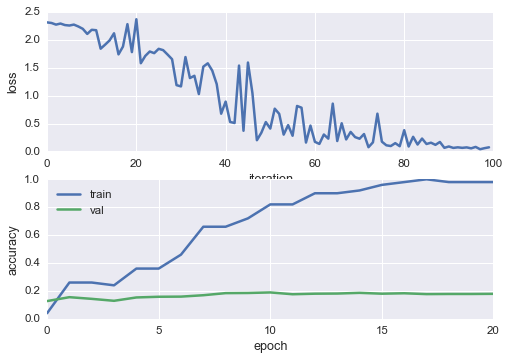

In [6]:
plt.subplot(2, 1, 1)
plt.plot(loss_history)
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

# Train the net
Once the above works, training the net is the next thing to try. You can set the `acc_frequency` parameter to change the frequency at which the training and validation set accuracies are tested. If your parameters are set properly, you should see the training and validation accuracy start to improve within a hundred iterations, and you should be able to train a reasonable model with just one epoch.

Using the parameters below you should be able to get around 50% accuracy on the validation set.

In [7]:
model = init_two_layer_convnet(filter_size=7)
trainer = ClassifierTrainer()
best_model, loss_history, train_acc_history, val_acc_history = trainer.train(
          X_train, y_train, X_val, y_val, model, two_layer_convnet,
          reg=0.001, momentum=0.9, learning_rate=0.0001, batch_size=50, num_epochs=1,
          acc_frequency=50, verbose=True)

starting iteration  0
Finished epoch 0 / 1: cost 2.300839, train: 0.089000, val 0.100000, lr 1.000000e-04
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
Finished epoch 0 / 1: cost 1.920032, train: 0.337000, val 0.302000, lr 1.000000e-04
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
starting iteration  100
Finished epoch 0 / 1: cost 1.733207, train: 0.378000, val 0.362000, lr 1.000000e-04
starting iteration  110
starting iteration  120
starting iteration  130
starting iteration  140
starting iteration  150
Finished epoch 0 / 1: cost 1.782129, train: 0.429000, val 0.402000, lr 1.000000e-04
starting iteration  160
starting iteration  170
starting iteration  180
starting iteration  190
starting iteration  200
Finished epoch 0 / 1: cost 1.554479, train: 0.401000, val 0.392000, lr 1.000000e-04
starting iteration  210
starting iteration  220
starting iteration  230
starting iterat

# Visualize weights
We can visualize the convolutional weights from the first layer. If everything worked properly, these will usually be edges and blobs of various colors and orientations.

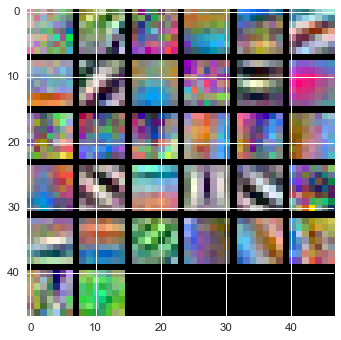

In [8]:
from cs231n.vis_utils import visualize_grid

grid = visualize_grid(best_model['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))

# Experiment!
Experiment and try to get the best performance that you can on CIFAR-10 using a ConvNet. Here are some ideas to get you started:

### Things you should try:
- Filter size: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- Number of filters: Above we used 32 filters. Do more or fewer do better?
- Network depth: The network above has two layers of trainable parameters. Can you do better with a deeper network? You can implement alternative architectures in the file `cs231n/classifiers/convnet.py`. Some good architectures to try include:
    - [conv-relu-pool]xN - conv - relu - [affine]xM - [softmax or SVM]
    - [conv-relu-pool]XN - [affine]XM - [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN - [affine]xM - [softmax or SVM]

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the course-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum and RMSprop; you could try alternatives like AdaGrad or AdaDelta.
- Other forms of regularization such as L1 or Dropout
- Alternative activation functions such as leaky ReLU or maxout
- Model ensembles
- Data augmentation

### What we expect
At the very least, you should be able to train a ConvNet that gets at least 65% accuracy on the validation set. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training, validation, and test set accuracies for your final trained network. In this notebook you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network.

Have fun and happy training!

In [9]:
# TODO: Train a ConvNet to do really well on CIFAR-10!
model = init_two_layer_convnet(filter_size=3,num_filters=128)
trainer = ClassifierTrainer()
best_model, loss_history, train_acc_history, val_acc_history = trainer.train(
          X_train, y_train, X_val, y_val, model, two_layer_convnet,
          reg=0.001, momentum=0.9, learning_rate=0.0001, batch_size=50, num_epochs=5,
          acc_frequency=50, verbose=True)

starting iteration  0
Finished epoch 0 / 5: cost 2.301227, train: 0.123000, val 0.130000, lr 1.000000e-04
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
Finished epoch 0 / 5: cost 2.065422, train: 0.354000, val 0.352000, lr 1.000000e-04
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
starting iteration  100
Finished epoch 0 / 5: cost 1.746886, train: 0.399000, val 0.406000, lr 1.000000e-04
starting iteration  110
starting iteration  120
starting iteration  130
starting iteration  140
starting iteration  150
Finished epoch 0 / 5: cost 1.300317, train: 0.415000, val 0.423000, lr 1.000000e-04
starting iteration  160
starting iteration  170
starting iteration  180
starting iteration  190
starting iteration  200
Finished epoch 0 / 5: cost 1.597422, train: 0.457000, val 0.451000, lr 1.000000e-04
starting iteration  210
starting iteration  220
starting iteration  230
starting iterat